# Background and Context
Businesses like banks that provide service have to worry about the problem of 'Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on the improvement of service, keeping in mind these priorities.


# Objective
Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.

# Data Dictionary
* CustomerId: Unique ID which is assigned to each customer
* Surname: Last name of the customer 
* CreditScore: It defines the credit history of the customer.  
* Geography: A customer’s location    
* Gender: It defines the Gender of the customer   
* Age: Age of the customer     
* Tenure: Number of years for which the customer has been with the bank
* NumOfProducts: It refers to the number of products that a customer has purchased through the bank.
* Balance: Account balance
* HasCrCard: It is a categorical variable that decides whether the customer has a credit card or not.
* EstimatedSalary: Estimated salary 
* isActiveMember: It is a categorical variable that decides whether the customer is an active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions, etc )
* Exited: It is a categorical variable that decides whether the customer left the bank within six months or not. It can take two values 
                    0=No ( Customer did not leave the bank )

                    1=Yes ( Customer left the bank )

In [1]:
# in order to get reproducible outputs, must set 4 random states
PYTHONHASHSEED=0  # step 1: set the PYTHONHASHSEED environment variable to 0 before the program starts

import random
random.seed(28)  # step 2: set `python` built-in pseudo-random generator at a fixed value

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(121)  # step 3: set `numpy` pseudo-random generator at a fixed value

import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(3)  # step 4: set the `tensorflow` pseudo-random generator at a fixed value

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.utils import class_weight

import keras_tuner as kt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set()
pd.set_option('display.max_columns', None)

# Import Data

In [2]:
bank = pd.read_csv("bank.csv")

In [3]:
df = bank.copy()

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Check shape and datatypes

In [5]:
df.shape

(10000, 14)

- The dataset consists of 10000 rows and 14 columns.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


- `Surname`, `Geography` and `Gender` are objects. Others are numbers.

## Check missing values

In [7]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

- No missing values.

## Check duplicates

In [8]:
np.any(df.duplicated())

False

- No duplicate rows.

## Check unique values

In [9]:
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

- `RowNumber` and `CustomerId` and are not releveant features, because we have distinct `RowNumber` and `CustomerId` for each customer.
- By common sense, we know `Surname` should not correlate with churn rate.

### Drop `RowNumber`, `CustomerId`, `Surname`

In [10]:
df = df.drop(columns = ["RowNumber", "CustomerId", "Surname"])

## Data summary

In [11]:
df.describe(include = "all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,NaN,NaN,NaN,650.5288,96.653299,350.0,584.0,652.0,718.0,850.0
Geography,10000,3,France,5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,10000,2,Male,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,10000.0,NaN,NaN,NaN,38.9218,10.487806,18.0,32.0,37.0,44.0,92.0
Tenure,10000.0,NaN,NaN,NaN,5.0128,2.892174,0.0,3.0,5.0,7.0,10.0
Balance,10000.0,NaN,NaN,NaN,76485.889288,62397.405202,0.0,0.0,97198.54,127644.24,250898.09
NumOfProducts,10000.0,NaN,NaN,NaN,1.5302,0.581654,1.0,1.0,1.0,2.0,4.0
HasCrCard,10000.0,NaN,NaN,NaN,0.7055,0.45584,0.0,0.0,1.0,1.0,1.0
IsActiveMember,10000.0,NaN,NaN,NaN,0.5151,0.499797,0.0,0.0,1.0,1.0,1.0
EstimatedSalary,10000.0,NaN,NaN,NaN,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48


- The magnitude of predictors varies from 1 to 250000. Need to standardize predictors before model building. 

# Univariate Analysis

In [12]:
def hist_box_plot(df, col):
    plt.figure(figsize = (15,5));
    plt.subplot(121);
    sns.histplot(x = col, data = df, kde = True);
    plt.subplot(122);
    sns.boxplot(x = col, data = df, showmeans = True, color = "yellow");

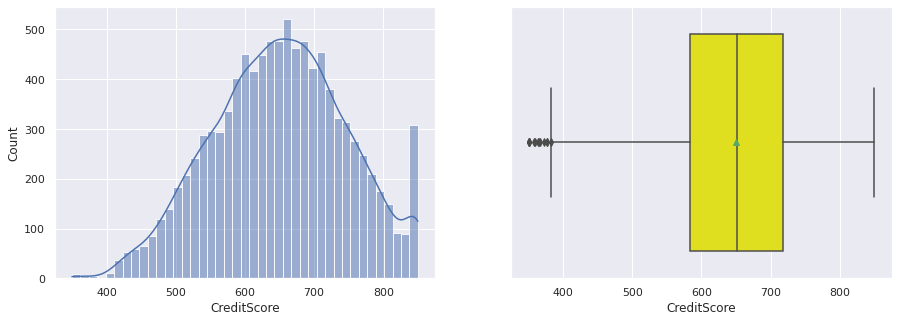

In [13]:
hist_box_plot(df, "CreditScore")

- `CreditScore` approaches normal distribution and ranges from 350 to 850 with almost equal mean and median. A few outliers on the left.

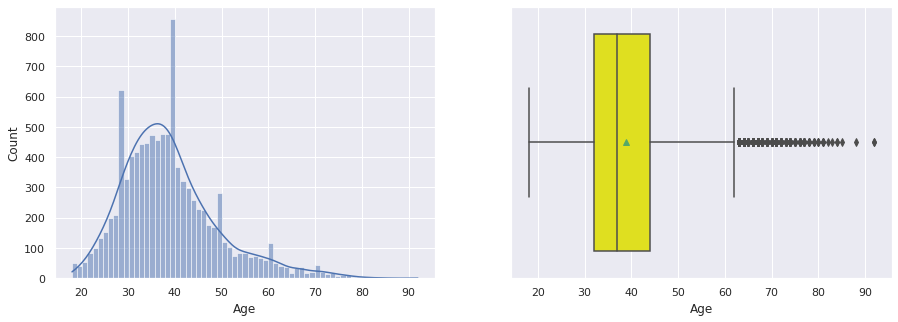

In [14]:
hist_box_plot(df, "Age")

- `Age` is right-skewed and ranges from 18 to 92. Half are under 35 years old. A number of outliers on the right.

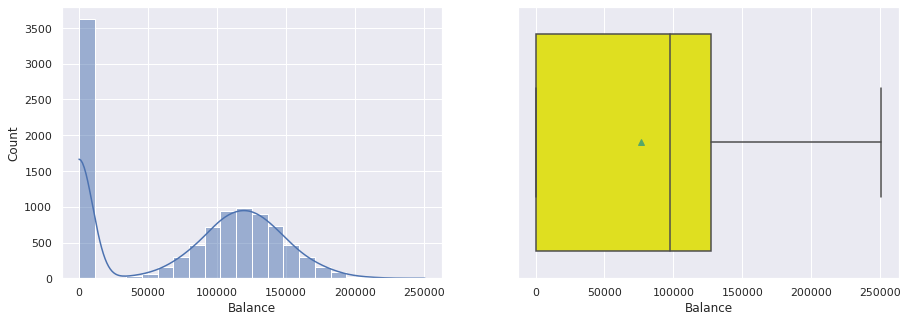

In [15]:
hist_box_plot(df, "Balance")

- At least 25% of the customers are with zero account balance. The rest of data constitutes a normal distribution. Overall it's left-skewed.

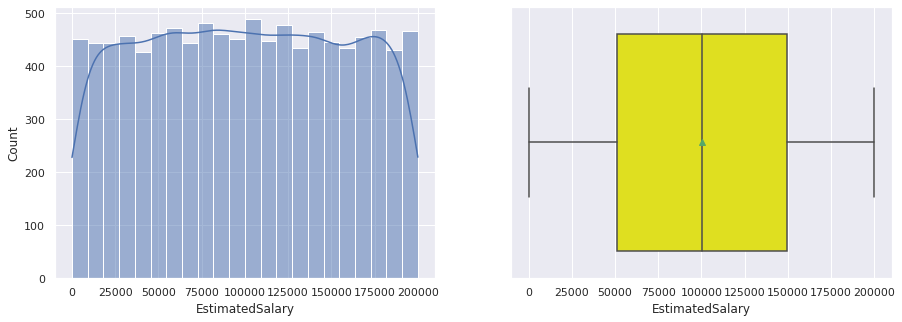

In [16]:
hist_box_plot(df, "EstimatedSalary")

- `EstimatedSalary` is evenly distributed with equal mean and median.

In [17]:
def countplot(col, figsize):
    plt.figure(figsize = figsize)
    ax = sns.countplot(x = col, data = df);
    for p in ax.patches:
        x, y = p.get_x(), p.get_y()
        h, w = p.get_height(), p.get_width()
        percent = np.round(h / df.shape[0] * 100, 2)
        plt.annotate(xy = (x + w/2 - 0.3, y + h), text = str(percent) + "%")

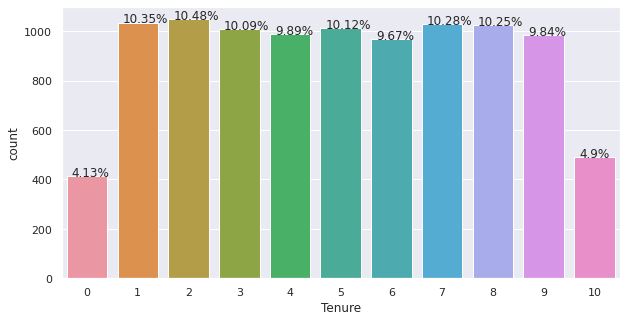

In [18]:
countplot("Tenure", figsize = (10,5))

- Most customers have been with our bank for 1 - 9 years, who are evenly distributed in this range of tenure.
- 4% of customers are new customers with less than 1 year of tenure.
- 5% of customers are loyal customers with 10 years of tenure.

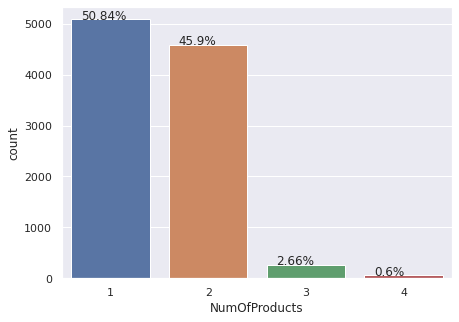

In [19]:
countplot("NumOfProducts", figsize = (7,5))

- 50.8% of customers bought 1 product and 46% of customers bought 2 products.
- 3% of customers bought more than two products.

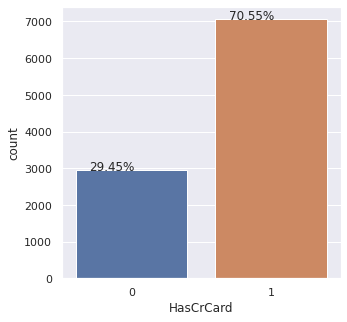

In [20]:
countplot("HasCrCard", figsize = (5,5))

- More than 70% of the customers have credit cards.

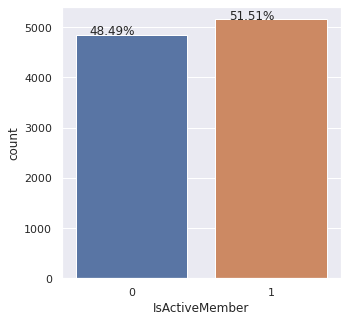

In [21]:
countplot("IsActiveMember", figsize = (5,5))

- About half of customers are active members.

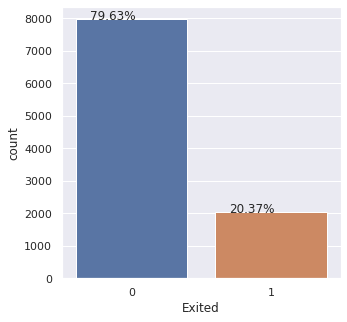

In [22]:
countplot("Exited", figsize = (5,5))

- Imbalanced classes. About 20% churn rate.

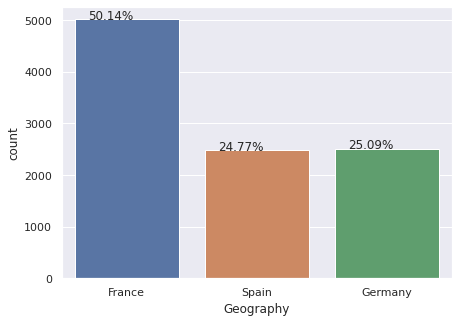

In [23]:
countplot("Geography", figsize = (7,5))

- Half of the customers come from France. The rest are evenly distributed between Spain and Germany.

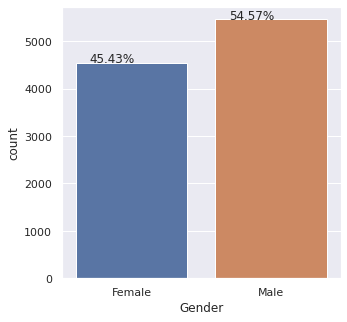

In [24]:
countplot("Gender", figsize = (5,5))

- Male is more than female. 54.6% of the customers are male.

# Bivariate Analysis
## Pairplot

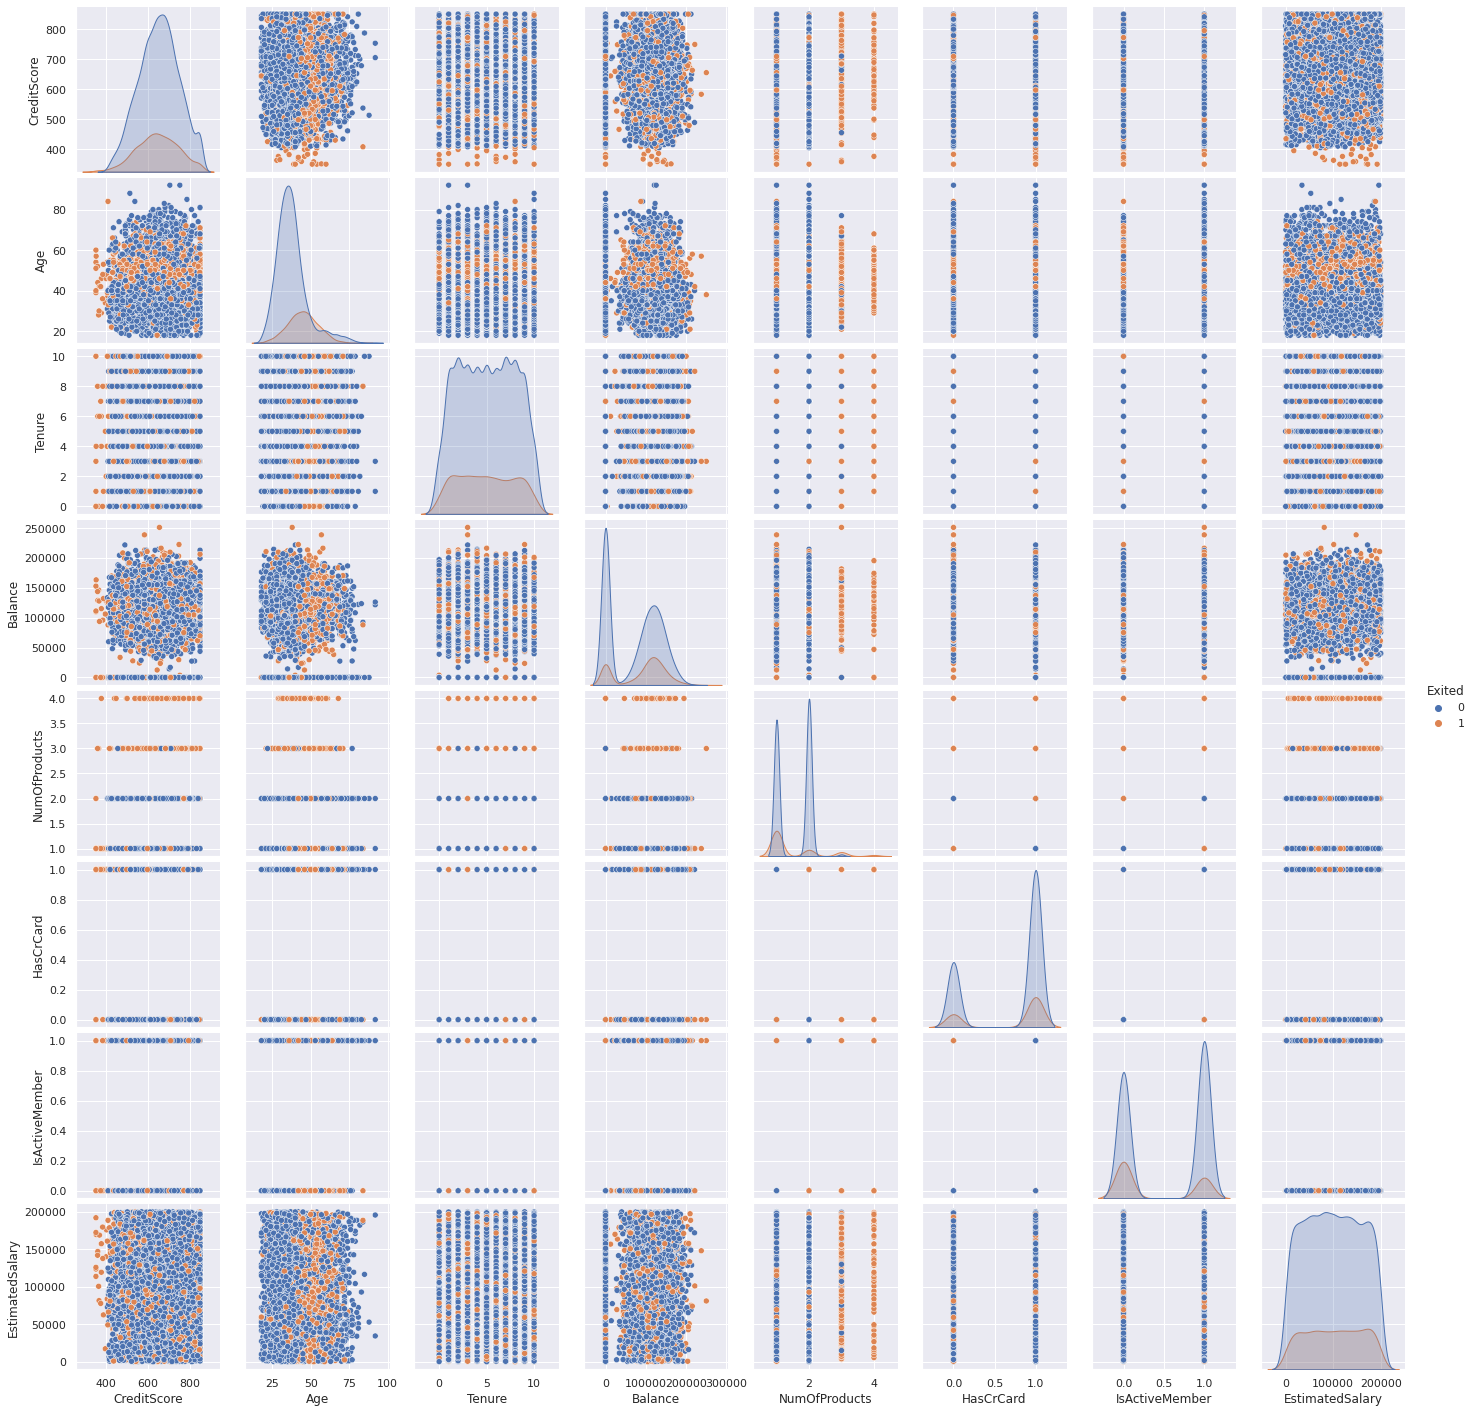

In [25]:
sns.pairplot(data = df, diag_kind = "kde", hue = "Exited");

## Heatmap

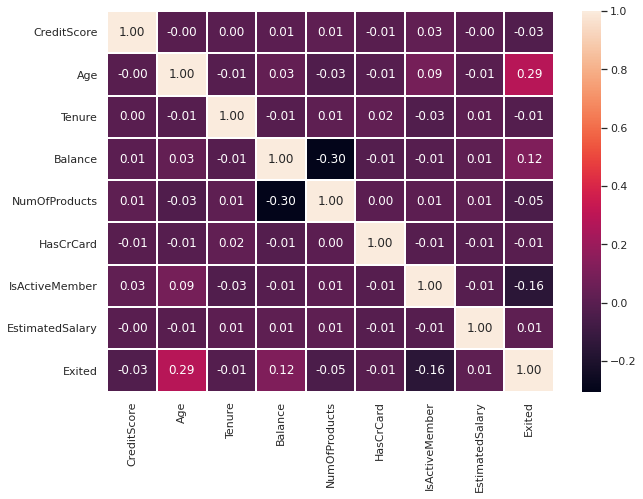

In [26]:
plt.figure(figsize = (10,7));
sns.heatmap(data = df.corr(), fmt = ".2f", annot = True, linewidths = 0.01);

- `NumOfProducts` is negatively correlated to `Balance`.
- `Exited` is positively correlated to `Age`.

## Exited vs Age

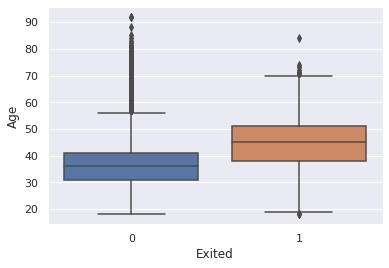

In [27]:
sns.boxplot(x = "Exited", y = "Age", data = df);

- Churned customers have higher median age of 45, while the median age of non-churned customers is about 35. Both groups have a number of outliers on the upper end.

## Exited vs CreditScore

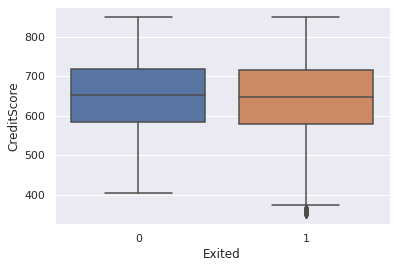

In [28]:
sns.boxplot(x = "Exited", y = "CreditScore", data = df);

- Not much difference in credit score distribution for both groups. 

## Exited vs Geography

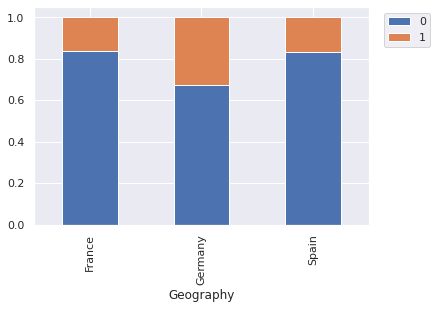

In [29]:
pd.crosstab(index = df.Geography, columns = df.Exited, normalize = "index").plot(kind = "bar", stacked = True);
plt.legend(bbox_to_anchor = (1.2,1), loc = "upper right");

- Germany has the highest churn rate which is around 30%, while France and Spain have almost equal churn rate of around 18%.

## Exited vs Gender

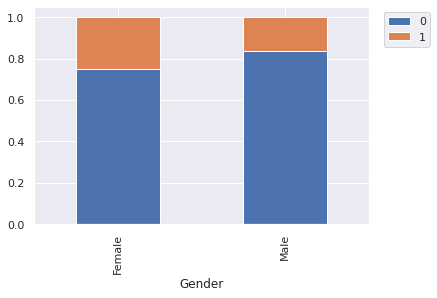

In [30]:
pd.crosstab(index = df.Gender, columns = df.Exited, normalize = "index").plot(kind = "bar", stacked = True);
plt.legend(bbox_to_anchor = (1.2,1), loc = "upper right");

- Female has higher churn rate than male.

## Exited vs Tenure

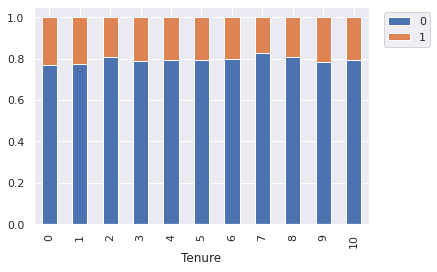

In [31]:
pd.crosstab(index = df.Tenure, columns = df.Exited, normalize = "index").plot(kind = "bar", stacked = True);
plt.legend(bbox_to_anchor = (1.2,1), loc = "upper right");

- Tenure doesn't affect churn rate.

## Exited vs Balance

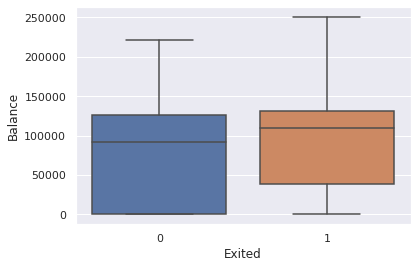

In [32]:
sns.boxplot(x = "Exited", y = "Balance", data = df);

- Churned customers have higher balance.

## Exited vs NumOfProducts

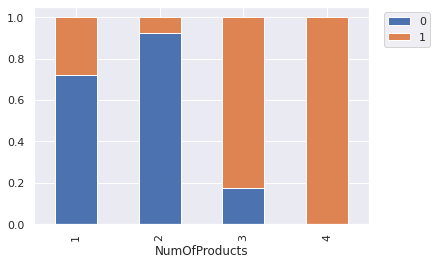

In [33]:
pd.crosstab(index = df.NumOfProducts, columns = df.Exited, normalize = "index").plot(kind = "bar", stacked = True);
plt.legend(bbox_to_anchor = (1.2,1), loc = "upper right");

- Customers who bought 3 or 4 products through our bank have significantly higher churn rates.
- Customers who bought 2 products have the lowest churn rate.
- It may indicate there's something wrong with our products, which makes our customers unhappy and finally drives them to the decision of leaving.

## Exited vs HasCrCard

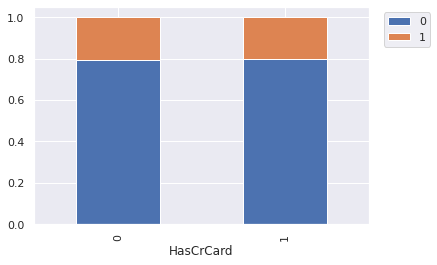

In [34]:
pd.crosstab(index = df.HasCrCard, columns = df.Exited, normalize = "index").plot(kind = "bar", stacked = True);
plt.legend(bbox_to_anchor = (1.2,1), loc = "upper right");

- The ownership of credit cards doesn't affect churn rate.

## Exited vs IsActiveMember

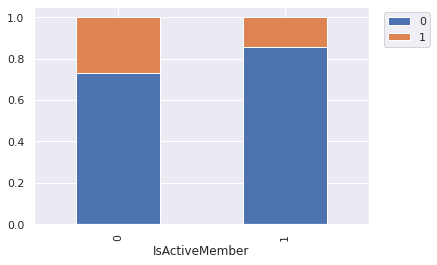

In [35]:
pd.crosstab(index = df.IsActiveMember, columns = df.Exited, normalize = "index").plot(kind = "bar", stacked = True);
plt.legend(bbox_to_anchor = (1.2,1), loc = "upper right");

- Active members are less likely to churn.

## Exited vs EstimatedSalary

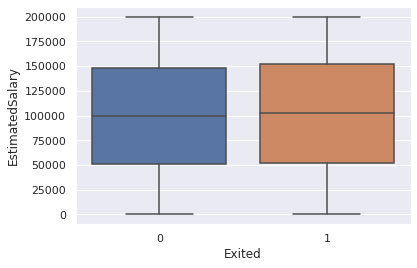

In [36]:
sns.boxplot(x = "Exited", y = "EstimatedSalary", data = df);

- `EstimatedSalary` doesn't affect churn rate.

## Exited vs Geography vs Age

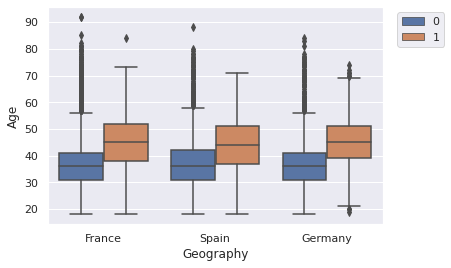

In [37]:
sns.boxplot(x = "Geography", y = "Age", hue = "Exited",data = df);
plt.legend(bbox_to_anchor = (1.2,1), loc = "upper right");

- Churned customers have higher median age than non-churned customers among all three countries.

## Exited vs Geography vs Gender

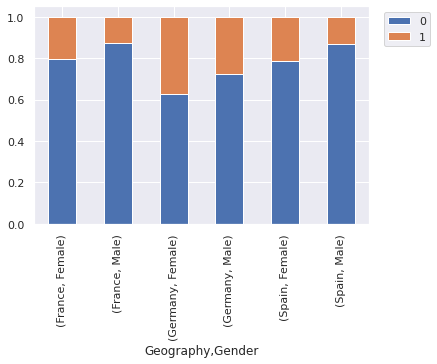

In [38]:
pd.crosstab(index = [df.Geography, df.Gender], columns = df.Exited, normalize = "index").plot(kind = "bar", stacked = True);
plt.legend(bbox_to_anchor = (1.2,1), loc = "upper right");

- Female is more likely to churn than male no matter in any of the three countries.

## Exited vs NumOfProducts vs EstimatedSalary

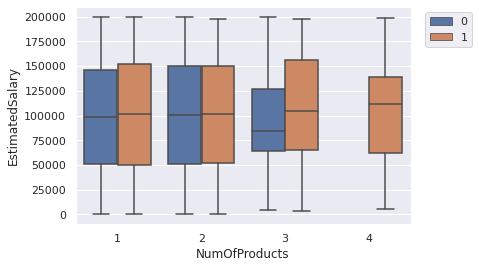

In [39]:
sns.boxplot(x = "NumOfProducts", y = "EstimatedSalary", hue = "Exited", data = df);
plt.legend(bbox_to_anchor = (1.2,1), loc = "upper right");

- For customers who bought the same amount of products, the churned group always has equal or higher estimated salary than the non-churned group. 
- The median estimated salary of churned customers who bought 4 products is the highest among all churned groups.

## Exited vs Geography vs Tenure

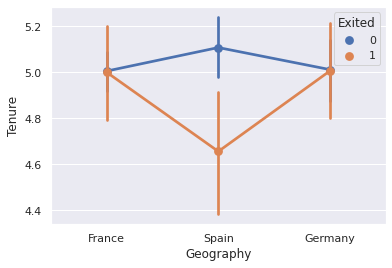

In [40]:
sns.pointplot(x = "Geography", y = "Tenure", hue = "Exited", data = df);

- Churned customers in Spain have lower tenure than non-churned customers, while in France and Germany both groups have equal tenure.

## Exited vs Gender vs Tenure

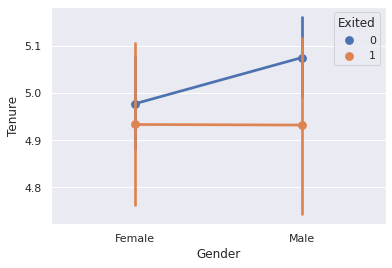

In [41]:
sns.pointplot(x = "Gender", y = "Tenure", hue = "Exited", data = df);

- Churned customers have lower tenure for both genders.

## Exited vs Age vs EstimatedSalary

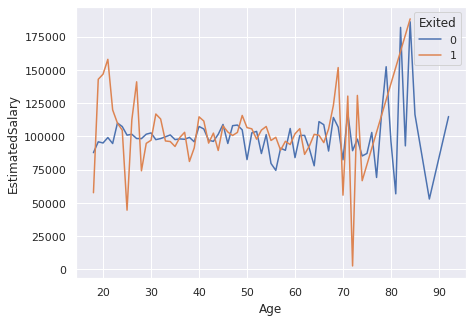

In [42]:
plt.figure(figsize = (7,5));
sns.lineplot(x = "Age", y = "EstimatedSalary", hue = "Exited", data = df, ci = None);

- Churned customers tend to have more unstable estimated salary than non-churned customers.

## Exited vs Age vs CreditScore

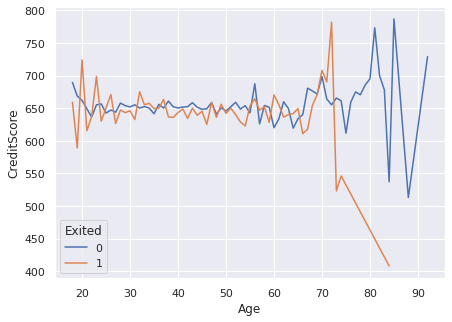

In [43]:
plt.figure(figsize = (7,5));
sns.lineplot(x = "Age", y = "CreditScore", hue = "Exited", data = df, ci = None);

- Churned customers older than 72 show a sharp decline of credit score compared to non-churned customers at the same age.

## Exited vs Age vs Balance

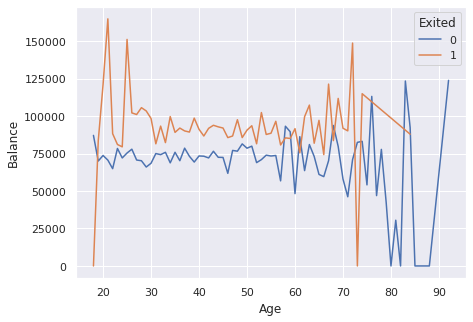

In [44]:
plt.figure(figsize = (7,5));
sns.lineplot(x = "Age", y = "Balance", hue = "Exited", data = df, ci = None);

- Generally speaking, churned customers have higher balance at all ages.

## Exited vs Age vs Tenure

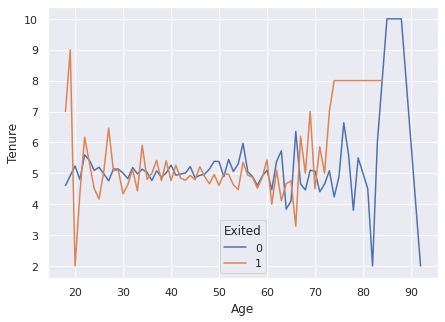

In [45]:
plt.figure(figsize = (7,5));
sns.lineplot(x = "Age", y = "Tenure", hue = "Exited", data = df, ci = None);

- Both groups show equal average tenure of about 5 years before 70 years old. Churned group shows increased tenure after 70 years old, while non-churned group shows a decline of tenure before 80 and then an increase of tenure after 80.

## Exited vs Geography vs Balance

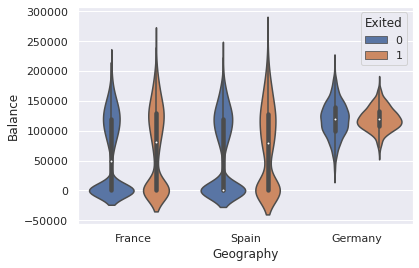

In [46]:
sns.violinplot(x = "Geography",y = "Balance", hue = "Exited", data = df);

- Germany: both groups have similar distribution of balance. The range of balance for both groups is smaller than that of the other two countries.
- Spain: the median balance of churned group is much higher than the non-churned group. In the non-churned group, at least half have zero balance.
- France: the median balance of churned group is slightly higher than the non-churned group. The range of balance is similar to that of Spain.

## Exited vs Gender vs EstimatedSalary

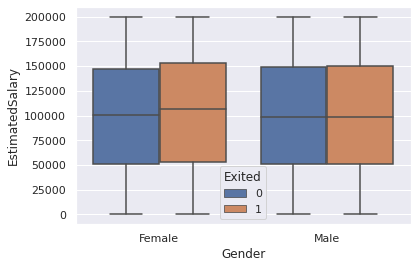

In [47]:
sns.boxplot(x = "Gender",y = "EstimatedSalary", hue = "Exited", data = df);

- Female: churned customers have slightly higher estimated salary than non-churned female customers. 
- Male: both groups show identical distribution of estimated salary.

## Exited vs Tenure vs Balance

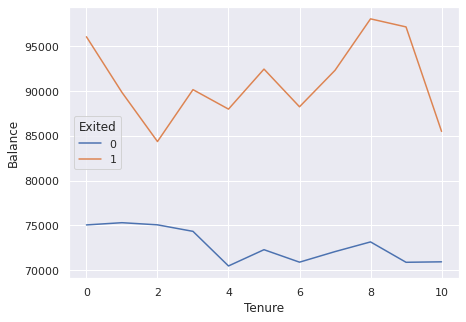

In [48]:
plt.figure(figsize = (7,5));
sns.lineplot(x = "Tenure", y = "Balance", hue = "Exited", data = df, ci = None);

- Churned customers with any tenure have higher balance.

## Exited vs Tenure vs CreditScore

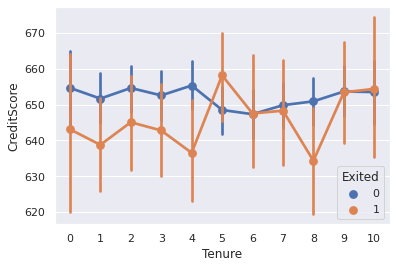

In [49]:
sns.pointplot(x = "Tenure", y = "CreditScore", hue = "Exited", data = df);

- Churned customers with 5 years of tenure have the highest average credit score among customers in any combinations of `Exited` and `Tenure`. They also have higher credit score than non-churned customers with the same tenure, while churned customers with other tenure tend to have lower credit score than non-churned customers with the same tenure.

## Exited vs Tenure vs EstimatedSalary

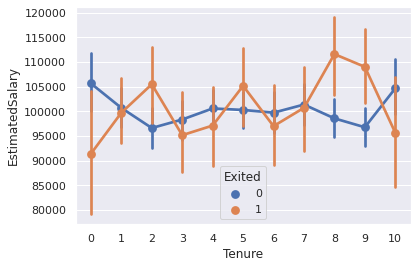

In [50]:
sns.pointplot(x = "Tenure", y = "EstimatedSalary", hue = "Exited", data = df);

- Churned customers with long tenure of 8 - 9 years have the highest estimated salary.

## Exited vs NumOfProducts vs Balance

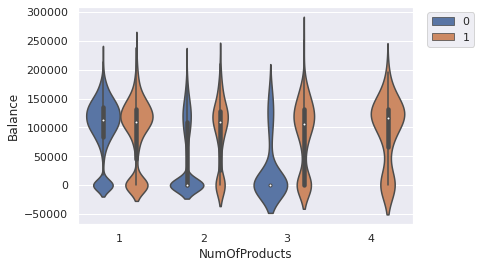

In [51]:
sns.violinplot(x = "NumOfProducts", y = "Balance", hue = "Exited", data = df);
plt.legend(bbox_to_anchor = (1.2,1), loc = "upper right");

- For customers who bought the same amount of products, the churned group always has equal or higher balance compared to the non-churned group. 
- The median balance of churned customers who bought 4 products is the highest among all churned groups.

## Geography vs Balance

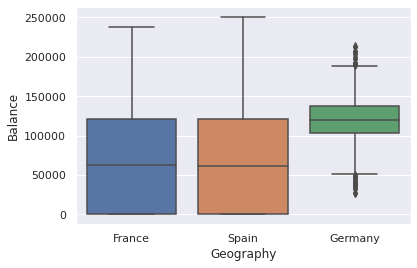

In [52]:
sns.boxplot(x = "Geography", y = "Balance", data = df);

- Customers at Germany have the highest median balance among three countries.

# Data Pre-processing

## Create dummy variable

In [53]:
df = pd.get_dummies(df, drop_first = True);
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


## Split data

In [54]:
X = df.drop(columns = ["Exited"])
y = df.Exited

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 17, shuffle = True, stratify = y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 17, shuffle = True, stratify = y_train)
print("Training set: ", X_train.shape, y_train.shape)          # 64% for training set
print("Validation set: ", X_valid.shape, y_valid.shape)  # 16% for validation set
print("Test set: ", X_test.shape, y_test.shape)              # 20% for test set

Training set:  (6400, 11) (6400,)
Validation set:  (1600, 11) (1600,)
Test set:  (2000, 11) (2000,)


In [56]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
4941,640,43,9,172478.15,1,1,0,191084.40,0,1,1
7747,850,24,6,0.00,2,1,1,13159.90,0,0,0
450,494,38,7,174937.64,1,1,0,40084.32,1,0,0
8264,742,33,6,0.00,2,0,0,38550.40,0,0,1
8485,670,25,7,0.00,2,1,1,144723.38,0,0,1


## Outlier treatment

`CreditScore` and `Age` have outliers. But these data points are not isolated from the remaining ones. Instead, they're the extension of the major part. We could leave them as is.

## Scaling
Only standardize the numerical columns.

In [57]:
ct = ColumnTransformer(transformers = [("scaler", StandardScaler(), ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary"])],
                      remainder = "passthrough", n_jobs= -1)

X_train_scaled = ct.fit_transform(X_train)
X_valid_scaled = ct.transform(X_valid)
X_test_scaled = ct.transform(X_test)

# Model building

## Metrics
**When we make a prediction, there're two types of errors:**
- Type I error (False Positive): A customer isn't going to churn, but we predict she/ he plans to. If we make this type of error, we will lose nothing.
- Type II error (Flase Negative): A customer is going to churn, but we predict she/ he isn't. If we make this type of error, we may lose valuable customers and the revenue associated with their accounts and transactions.

**Our goal is to identify as many churned customers as possible, therefore we should use recall and accuracy as metrics.**

In [58]:
def history_loss(history):
    """
    Plot training history.
    """
    plt.figure(figsize = (20,5));

    plt.subplot(121);   # plot accuracy curve
    plt.plot(history.history["accuracy"], label = "train");
    plt.plot(history.history["val_accuracy"], label = "validation");
    plt.legend(loc = "lower right");
    plt.title("Accuracy");

    plt.subplot(122);    # plot loss curve
    plt.plot(history.history["loss"], label = "train");
    plt.plot(history.history["val_loss"], label = "validation");
    plt.legend(loc = "upper right");
    plt.title("Loss");

In [59]:
def roc_auc(y_true, y_prob):
    """
    Compute roc_auc score and show the roc curve. 
    
    Input:
    y_true: ground truth of class.
    y_prob: predicted probability.
    
    Return:
    FPR, TPR and thresholds returned by roc_curve().
    """
    fpr, tpr, threshold = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    plt.figure(figsize = (5,5));
    plt.plot([0,1],[0,1], "r--", label = "baseline");
    plt.plot(fpr, tpr, "b--", label = "roc-auc");
    plt.xlim(-0.01, 1.01);
    plt.ylim(-0.01, 1.01);
    plt.xlabel("FPR");
    plt.ylabel("TPR");
    plt.legend(loc = "lower right");
    plt.title("AUC score:" + str(np.round(auc, 3)));
    return fpr, tpr, threshold

In [60]:
def performance_metrics(model, thresh, X_train, y_train, X_test, y_test):   
    """
    Convert probability to class label according to thresh. Compute accuracy, recall and precision for train/ test set.
    
    Input:
    model: fitted model.
    thresh: threshold for predicted probability to be set to label 1.
    X_train, y_train: training set and labels.
    X_test, y_test: test set and labels.
    
    Return:
    y_test_pred: predicted class for test set.
    metrics: metrics dataframe.
    """
    y_train_pred = (model.predict(X_train) > thresh).astype("int32")
    y_test_pred = (model.predict(X_test) > thresh).astype("int32")
    
    m = []
    m.append(accuracy_score(y_train, y_train_pred))
    m.append(accuracy_score(y_test, y_test_pred))    

    m.append(recall_score(y_train, y_train_pred))
    m.append(recall_score(y_test, y_test_pred))
  
    m.append(precision_score(y_train, y_train_pred))
    m.append(precision_score(y_test, y_test_pred))
    
    metrics = pd.DataFrame(data = m, index = ["Train Accuracy", "Test Accuracy", "Train Recall",  "Test Recall", "Train Precision", "Test Precision"])
    return y_test_pred, metrics.T

In [61]:
def show_confusion_matrix(y_true, y_pred, labels = [0, 1]):
    """
    Show confusion matrix as heatmap.
    
    Input:
    y_true: ground truth of class.
    y_pred: predicted class.
    labels: class labels.
    
    Return:
    None.
    """
    matrix = confusion_matrix(y_true, y_pred, labels = labels)
    matrix_df = pd.DataFrame(matrix)
    
    group_counts = ["{0:0.0f}".format(value) for value in matrix.flatten()]   # absolute value
    group_percentages = ["{0:.2%}".format(value) for value in matrix.flatten()/np.sum(matrix)]    # percent
    plot_labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
    plot_labels = np.asarray(plot_labels).reshape(2,2)   # reshape into a n_class x n_class ndarray
    
    plt.figure(figsize = (7,5))
    sns.heatmap(matrix_df, annot = plot_labels, fmt='')
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')

In [62]:
metrics = {}    # a dictionary to keep track of performance of different models

## Model 1
- Build a NN with two hidden layers.

In [63]:
def build_model1():
    model = keras.Sequential(name = "M1")
    model.add(keras.layers.Dense(units = 10, input_dim = X_train_scaled.shape[1], activation = "relu", kernel_initializer= "he_normal", name = "dense_1"))
    model.add(keras.layers.Dense(units = 4, activation = "relu", kernel_initializer= "he_normal", name = "dense_2"))
    model.add(keras.layers.Dense(units = 1, activation = "sigmoid", kernel_initializer= "glorot_normal", name = "output"))
    
    # use Adam as optimizer, binary_crossentropy as loss function and accuracy as metrics
    model.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = [ "accuracy" ])
    
    return model

In [64]:
m1 = build_model1()

# run 50 epochs
history = m1.fit(X_train_scaled, y_train, epochs=50, validation_data=(X_valid_scaled, y_valid), verbose = 0)  

In [65]:
m1.summary()   # architecture of model 1

Model: "M1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 44        
_________________________________________________________________
output (Dense)               (None, 1)                 5         
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


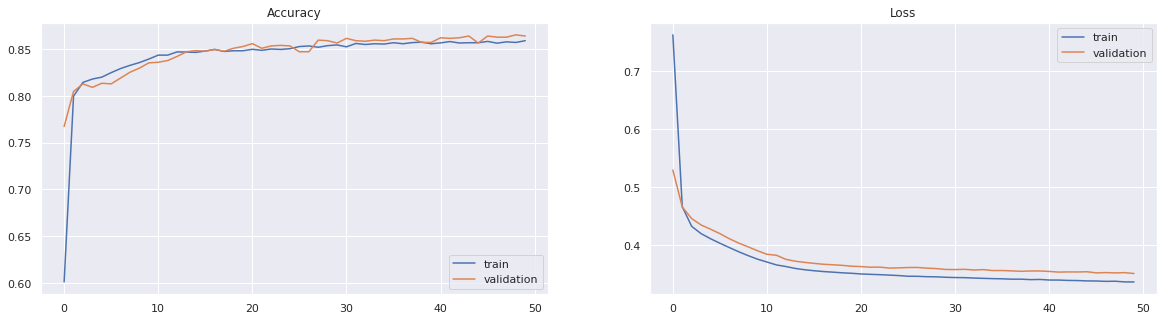

In [66]:
history_loss(history)

- After 10 epochs, accuracy becomes stable. 
- After 20 epochs, loss curve flattens. 

In [67]:
print("Evaluate training set:")
m1.evaluate(X_train_scaled, y_train)
print("Evaluate validation set:")
m1.evaluate(X_valid_scaled, y_valid)
print("Evaluate test set:")
m1.evaluate(X_test_scaled, y_test)

Evaluate training set:
200/200 [==============================] - 0s 716us/step - loss: 0.3356 - accuracy: 0.8606
Evaluate validation set:
50/50 [==============================] - 0s 1ms/step - loss: 0.3517 - accuracy: 0.8644
Evaluate test set:
63/63 [==============================] - 0s 1ms/step - loss: 0.3531 - accuracy: 0.8540


[0.35307806730270386, 0.8539999723434448]

- Loss and accuracy for train/ validation/ test set are alike.

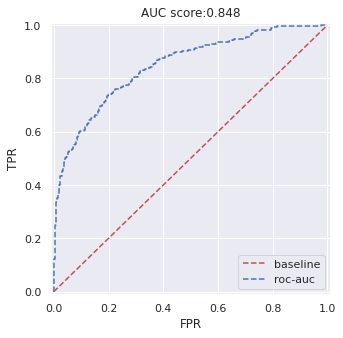

In [68]:
y_valid_prob = m1.predict(X_valid_scaled)     # find optimal threshold with validation set
fpr, tpr, threshold = roc_auc(y_valid, y_valid_prob)

In [69]:
idx = np.argmax(tpr - fpr)  # the index at which tpr and fpr achieve the maximum difference
optimal_thresh1 = threshold[idx]
print("optimal threshold:", optimal_thresh1)

optimal threshold: 0.21421847


In [70]:
y_test_pred, metrics["M1"] = performance_metrics(m1, optimal_thresh1, X_train_scaled, y_train, X_test_scaled, y_test)
metrics["M1"]

,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision
0,0.797969,0.7895,0.765337,0.742015,0.502771,0.488673


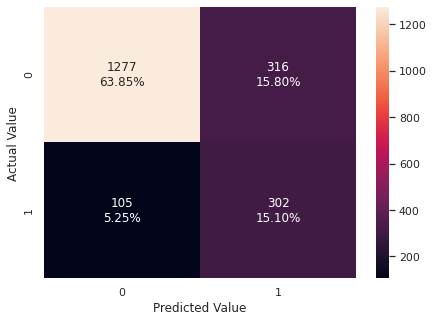

In [71]:
show_confusion_matrix(y_test, y_test_pred)

-  Although metricses of train/ test set are alike, they're not high enough. Maybe because the model is too simple to learn the pattern among the data.

## Model 2
- Keep the architecture of model 1, and add batch normalization.
- Based on earlier EDA, this's an imbalanced dataset. Add class weight to the model to penalize the errors made on class 1.

In [72]:
class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(y_train), y = np.array(y_train))
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.6279434850863422, 1: 2.4539877300613497}

In [73]:
def build_model2():
    model = keras.Sequential(name = "M2")

    model.add(keras.layers.Dense(units = 10, input_dim = X_train_scaled.shape[1], kernel_initializer= "he_normal", name = "dense_1")) 
    model.add(keras.layers.BatchNormalization(name = "batch_normalization_1"))
    model.add(keras.layers.Activation("relu", name = "relu_1"))

    model.add(keras.layers.Dense(units = 4, kernel_initializer= "he_normal", name = "dense_2"))
    model.add(keras.layers.BatchNormalization(name = "batch_normalization_2"))
    model.add(keras.layers.Activation("relu", name = "relu_2"))

    model.add(keras.layers.Dense(units = 1, activation = "sigmoid", kernel_initializer= "glorot_normal", name = "output"))
    
    # use Adam as optimizer, binary_crossentropy as loss function and accuracy as metrics
    model.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = [ "accuracy" ])
    
    return model

In [74]:
m2 = build_model2()

# run 50 epochs
history = m2.fit(X_train_scaled, y_train, epochs=50, validation_data=(X_valid_scaled, y_valid), class_weight = class_weights, verbose = 0)  

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [75]:
m2.summary()   # architecture of model 2

Model: "M2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                120       
_________________________________________________________________
batch_normalization_1 (Batch (None, 10)                40        
_________________________________________________________________
relu_1 (Activation)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 44        
_________________________________________________________________
batch_normalization_2 (Batch (None, 4)                 16        
_________________________________________________________________
relu_2 (Activation)          (None, 4)                 0         
_________________________________________________________________
output (Dense)               (None, 1)                 5        

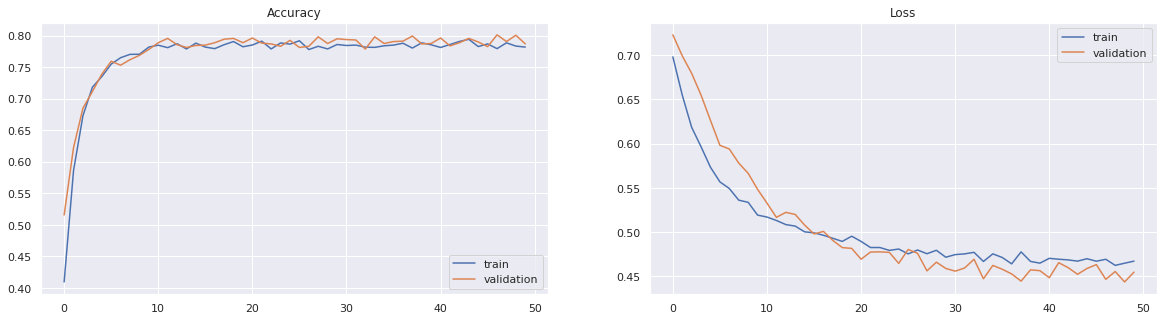

In [76]:
history_loss(history)

- The trend of accuracy curve and loss curve are similar to M1. 

In [77]:
print("Evaluate training set:")
m2.evaluate(X_train_scaled, y_train)
print("Evaluate validation set:")
m2.evaluate(X_valid_scaled, y_valid)
print("Evaluate test set:")
m2.evaluate(X_test_scaled, y_test)

Evaluate training set:
200/200 [==============================] - 0s 831us/step - loss: 0.4375 - accuracy: 0.8002
Evaluate validation set:
50/50 [==============================] - 0s 1ms/step - loss: 0.4546 - accuracy: 0.7869
Evaluate test set:
63/63 [==============================] - 0s 1ms/step - loss: 0.4589 - accuracy: 0.7960


[0.4588663876056671, 0.7960000038146973]

- Loss and accuracy for train/ validation/ test set are alike.

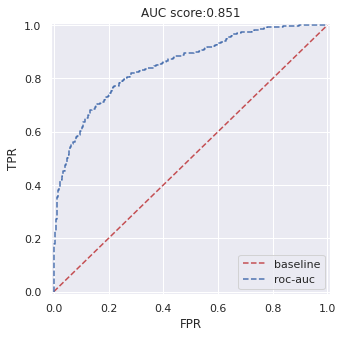

In [78]:
y_valid_prob = m2.predict(X_valid_scaled)       # find optimal threshold with validation set
fpr, tpr, threshold = roc_auc(y_valid, y_valid_prob)

In [79]:
idx = np.argmax(tpr - fpr)  # the index at which tpr and fpr achieve the maximum difference
optimal_thresh2 = threshold[idx]
print("optimal threshold:", optimal_thresh2)

optimal threshold: 0.4684015


In [80]:
y_test_pred, metrics["M2"] = performance_metrics(m2, optimal_thresh2, X_train_scaled, y_train, X_test_scaled, y_test)
metrics["M2"]

,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision
0,0.786406,0.777,0.792178,0.781327,0.485204,0.471111


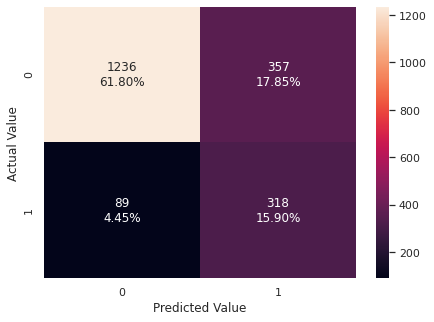

In [81]:
show_confusion_matrix(y_test, y_test_pred)

- Train/ Test set fit well. Recall gets improved by 5.3%.
- After applying class weight, the optimal threshold is close to the default threshold of 0.5.

## Model 3
- Build a larger and deeper NN, with batch normalization, weight constraints and dropout.
- Train for 80 epochs rather than 50 epochs.

In [82]:
max_norm = keras.constraints.MaxNorm(4)

In [83]:
def build_model3():
    model = keras.Sequential(name = "M3")

    model.add(keras.layers.Dense(units = 32, input_dim = X_train_scaled.shape[1], kernel_initializer= "he_normal", kernel_constraint = max_norm, 
                              name = "dense_1")) 
    model.add(keras.layers.BatchNormalization(name = "batch_normalization_1"))
    model.add(keras.layers.Activation("relu", name = "relu_1"))

    model.add(keras.layers.Dropout(0.3, name = "dropout_1"))

    model.add(keras.layers.Dense(units = 64, kernel_initializer= "he_normal", kernel_constraint = max_norm, name = "dense_2"))
    model.add(keras.layers.BatchNormalization(name = "batch_normalization_2"))
    model.add(keras.layers.Activation("relu", name = "relu_2"))

    model.add(keras.layers.Dropout(0.4, name = "dropout_2"))

    model.add(keras.layers.Dense(units = 32, kernel_initializer= "he_normal", kernel_constraint = max_norm, name = "dense_3"))
    model.add(keras.layers.BatchNormalization(name = "batch_normalization_3"))
    model.add(keras.layers.Activation("relu", name = "relu_3"))

    model.add(keras.layers.Dropout(0.3, name = "dropout_3"))

    model.add(keras.layers.Dense(units = 1, activation = "sigmoid", kernel_initializer= "glorot_normal", name = "output"))
    
    # use Adam as optimizer, binary_crossentropy as loss function and accuracy as metrics
    model.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = ["accuracy"] ) 
    
    return model

In [84]:
m3 = build_model3()

# run 80 epochs
history = m3.fit(X_train_scaled, y_train, epochs=80, validation_data=(X_valid_scaled, y_valid), verbose = 0)  

In [85]:
m3.summary()   # architecture of model 3

Model: "M3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                384       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
relu_1 (Activation)          (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
relu_2 (Activation)          (None, 64)                0        

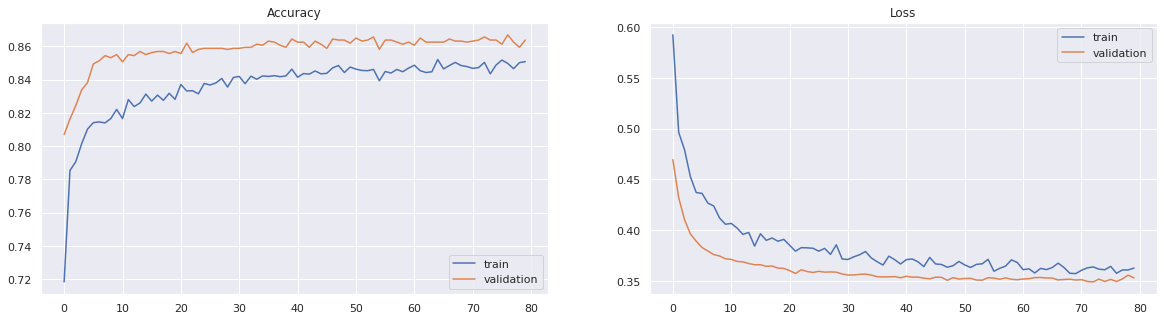

In [86]:
history_loss(history)

- Since the NN is deeper and larger, it takes more iterations to converge. After 40 epochs, both accuracy curve and loss curve flatten. 

In [87]:
print("Evaluate training set:")
m3.evaluate(X_train_scaled, y_train)
print("Evaluate validation set:")
m3.evaluate(X_valid_scaled, y_valid)
print("Evaluate test set:")
m3.evaluate(X_test_scaled, y_test)

Evaluate training set:
200/200 [==============================] - 0s 913us/step - loss: 0.3258 - accuracy: 0.8652
Evaluate validation set:
50/50 [==============================] - 0s 965us/step - loss: 0.3530 - accuracy: 0.8637
Evaluate test set:
63/63 [==============================] - 0s 1ms/step - loss: 0.3471 - accuracy: 0.8575


[0.3470853567123413, 0.8575000166893005]

- Loss and accuracy for train/ validation/ test set are alike.

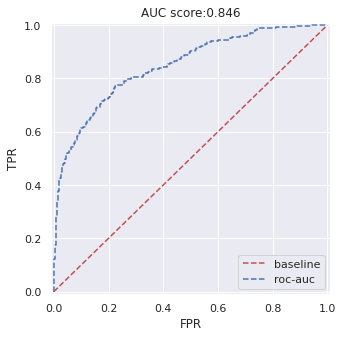

In [88]:
y_valid_prob = m3.predict(X_valid_scaled)       # find optimal threshold with validation set
fpr, tpr, threshold = roc_auc(y_valid, y_valid_prob)

In [89]:
idx = np.argmax(tpr - fpr)  # the index at which tpr and fpr achieve the maximum difference
optimal_thresh3 = threshold[idx]
print("optimal threshold:", optimal_thresh3)

optimal threshold: 0.1813586


In [90]:
y_test_pred, metrics["M3"] = performance_metrics(m3, optimal_thresh3, X_train_scaled, y_train, X_test_scaled, y_test)
metrics["M3"]

,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision
0,0.780625,0.765,0.809816,0.77887,0.477396,0.454806


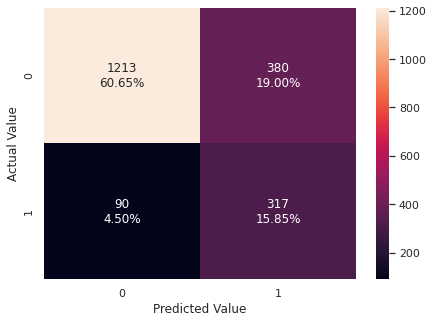

In [91]:
show_confusion_matrix(y_test, y_test_pred)

- Train/ Test set fit well. Recall gets improved by 5% compared to M1.

## Model 4

In [92]:
# def build_model4(hp):
#     model = keras.Sequential(name = "M4")

#     model.add(keras.layers.Dense(units = hp.Int('units1', min_value=1, max_value=100, step=1), input_dim = X_train_scaled.shape[1], 
#                                  kernel_initializer= "he_normal", kernel_constraint = max_norm, name = "dense_1")) 
#     model.add(keras.layers.BatchNormalization(name = "batch_normalization_1"))
#     model.add(keras.layers.Activation("relu", name = "relu_1"))

#     model.add(keras.layers.Dropout(rate = hp.Float('r1', min_value=0.2, max_value=0.6, step=0.05), name = "dropout_1"))

#     model.add(keras.layers.Dense(units = hp.Int('units2', min_value=1, max_value=100, step=1) , kernel_initializer= "he_normal", 
#                                  kernel_constraint = max_norm, name = "dense_2"))
#     model.add(keras.layers.BatchNormalization(name = "batch_normalization_2"))
#     model.add(keras.layers.Activation("relu", name = "relu_2"))

#     model.add(keras.layers.Dropout(rate = hp.Float('r2', min_value=0.2, max_value=0.6, step=0.05), name = "dropout_2"))

#     model.add(keras.layers.Dense(units = hp.Int('units3', min_value=1, max_value=100, step=1) , kernel_initializer= "he_normal", 
#                                  kernel_constraint = max_norm, name = "dense_3"))
#     model.add(keras.layers.BatchNormalization(name = "batch_normalization_3"))
#     model.add(keras.layers.Activation("relu", name = "relu_3"))

#     model.add(keras.layers.Dropout(rate = hp.Float('r3', min_value=0.2, max_value=0.6, step=0.05), name = "dropout_3"))

#     model.add(keras.layers.Dense(units = 1, activation = "sigmoid", kernel_initializer= "glorot_normal", name = "output"))
    
#     model.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = ["accuracy"] )
#     return model

In [93]:
# # search randomly for 200 model configurations, objective function is val_accuracy
# tuner = kt.RandomSearch(hypermodel = build_model4, objective = 'val_accuracy', max_trials = 200, overwrite=True, seed=9)

# # define early stopping callback to monitor the change of val_loss
# es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# # run 200 epochs
# tuner.search(X_train_scaled, y_train, epochs=200, validation_data=(X_valid_scaled, y_valid), callbacks=[es])

# # Get the optimal hyperparameters
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [94]:
# print( "units hidden layers: {}, {}, {}".format(best_hps.get('units1'), best_hps.get('units2'), best_hps.get('units3')) )
# print( "dropout rate: {}, {}, {}".format(best_hps.get('r1'), best_hps.get('r2'), best_hps.get('r3')) )

In [95]:
# # Build the model with the optimal hyperparameters and train it for 200 epochs
# m4 = tuner.hypermodel.build(best_hps)
# history = m4.fit(X_train_scaled, y_train, epochs=200, validation_data=(X_valid_scaled, y_valid), verbose = 0)

In [96]:
# val_acc_per_epoch = history.history['val_accuracy']
# best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
# print('Best epoch: %d' % (best_epoch))   # get the epoch when val_accuracy achieves the highest value

In [97]:
# m4 = tuner.hypermodel.build(best_hps)

# # Retrain the model
# history = m4.fit(X_train_scaled, y_train, epochs=best_epoch, validation_data=(X_valid_scaled, y_valid), verbose = 0)

In [98]:
# history_loss(history)

In [99]:
# m4.summary()

In [100]:
# print("Evaluate training set:")
# m4.evaluate(X_train_scaled, y_train)
# print("Evaluate validation set:")
# m4.evaluate(X_valid_scaled, y_valid)
# print("Evaluate test set:")
# m4.evaluate(X_test_scaled, y_test)

In [101]:
# y_valid_prob = m4.predict(X_valid_scaled)       # find optimal threshold with validation set
# fpr, tpr, threshold = roc_auc(y_valid, y_valid_prob)

In [102]:
# idx = np.argmax(tpr - fpr)  # the index at which tpr and fpr achieve the maximum difference
# optimal_thresh4 = threshold[idx]
# print("optimal threshold:", optimal_thresh4)

In [103]:
# y_test_pred, metrics["M4"] = performance_metrics(m4, optimal_thresh4, X_train_scaled, y_train, X_test_scaled, y_test)
# metrics["M4"]

In [104]:
# show_confusion_matrix(y_test, y_test_pred)

 ## Compare models

In [105]:
compare = pd.concat(metrics.values(), axis = 0)
compare["Model"] = list(metrics.keys())
compare.set_index("Model")

,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision
Model,,,,,,
M1,0.797969,0.7895,0.765337,0.742015,0.502771,0.488673
M2,0.786406,0.7770,0.792178,0.781327,0.485204,0.471111
M3,0.780625,0.7650,0.809816,0.778870,0.477396,0.454806


- All three models fit well both on train and test set. M2 is the best model.
- M1: the most basic model, acquires the lowest recall and highest accuracy and precision.
- M2: after applying batch normalization and weighted loss, recall is improved by 5.3% while accuracy and precision slightly decline.
- M3: a larger and deeper neural network with batch normalization, dropout and weight constraint, acquires almost as high a test recall score as M2, but accuracy and precision further decline.

# Conclusion
- Churned customers tend to be older no matter in any of the three countries.
- Customers at Germany have the highest median balance and churn rate among three countries.
- Female is more likely to churn than male no matter in any of the three countries.
- Churned customers with any tenure/ at all ages tend to have higher balance.
- Active members are less likely to churn.
- Customers who bought 3 or 4 products through our bank have significantly higher churn rate. It may indicate there's something wrong with our products, which makes our customers unhappy and finally drives them to the decision of leaving.

- For customers who bought the same amount of products, the churned group always has equal or higher estimated salary/balance than the non-churned group. The median estimated salary/balance of churned customers who bought 4 products is the highest among all churned groups.
- Churned customers in Spain have lower tenure than non-churned customers, while in France and Germany both groups have equal tenure.
- Churned customers have lower tenure for both genders.
- Churned customers tend to have more unstable estimated salary than non-churned customers.
- Churned customers older than 72 show a sharp decline of credit score.
- For female, churned customers have slightly higher estimated salary than non-churned customers. For male, both groups show identical distribution of estimated salary.
- Churned customers with 5 years of tenure have the highest average credit score among customers in any combinations of `Exited` and `Tenure`. 
- Churned customers with long tenure of 8 - 9 years have the highest estimated salary.




# Recommendation
- Customers who bought 3 or 4 products through our bank show a significantly higher churn rate. Need to investigate what products they bought and what cause them to leave. If possible, implement survey among all customers to find out their opinions about our products and services, and overhaul the design of our products and service quality.
- As Germany has a higher churn rate and higher median balance than other two countries, we need to improve marketing strategy in Germany to maintain these premium customers.
- As churned customers with any tenure/ at all ages tend to have higher balance, we should research on how to meet their needs to retain them. For example, to waive service fees and offer higher interest rate for their deposit accounts, to provide bonus for opening new accounts, etc.